### 實驗內容描述:
下載MTCNN跟FaceNet進行人臉分群和辨識 

###實驗結果:
人臉分群：
*   偵測五官位置
*   利用Face-Embedding分群

人臉辨識： 
*   使用Face-Embedding製作資料集
*   自訂model分類圖片

###結果討論與實驗心得:
非常有趣，期待之後能使用更多pre-trained的model來做有趣的機器學習


## 實驗前的準備

**下載 model 並載入 libraries**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model #讀取現成的model
import os
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import cv2
import numpy as np
import pickle
!pip install -U split_folders #分拆照片
try:
    import mtcnn #偵測人臉的model
except:
    !pip install mtcnn    
    import mtcnn

print('MTCNN版本：',mtcnn.__version__) #確認model已成功下載

# 用FaceNet提取臉部特徵
_URL = 'https://github.com/satinder147/Attendance-using-Face/raw/master/facenet_keras.h5'
local_path_to_facenet_h5 = tf.keras.utils.get_file('facenet_keras.h5',origin=_URL,cache_subdir='models',extract=False)
facenet = load_model(local_path_to_facenet_h5)

# 用tf.keras.utils.plot_model 來呈現model結構
facenet_arch = tf.keras.utils.plot_model(facenet, to_file='facenet.png',show_shapes=True, show_layer_names=True, dpi=64)
display(facenet_arch)

# 建立臉部的偵測器
detector = mtcnn.MTCNN()

Output hidden; open in https://colab.research.google.com to view.

## 人臉分群

**下載圖片**

106496/99393 [================================] - 0s 0us/step


(-0.5, 1079.5, 729.5, -0.5)

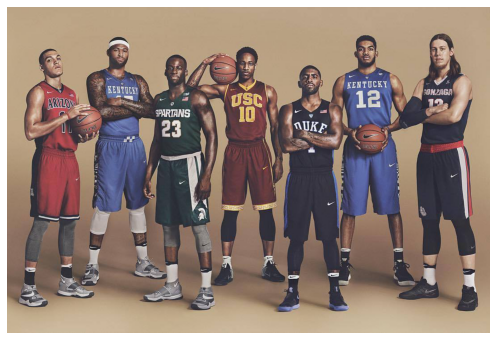

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import get_file

url  ='https://imgur.com/76cpssV.jpg'
name = 'Nike'
filename = get_file(name,origin=url)

image = load_img(filename)
pixels = img_to_array(image) #將圖片變成pixel陣列

#顯示圖片
plt.figure(figsize=(10,6))
plt.imshow(pixels / 255) #把RGB數值變成float
plt.axis(False) #不使用網格

#### 偵測人臉

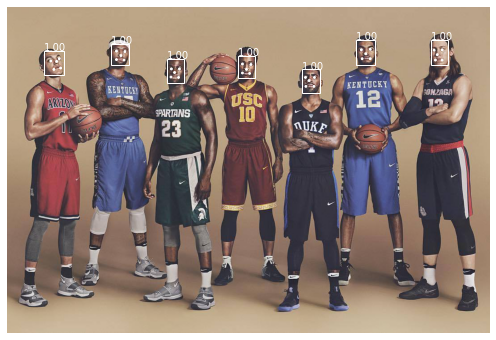

In [ ]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

#用MTCNN偵測人臉
faces = detector.detect_faces(pixels)

#顯示偵測人臉後的圖片
plt.figure(figsize=(10,6))
plt.imshow(pixels / 255) #把RGB數值變成float
plt.axis(False) #不使用網格
ax = plt.gca() #得到當前的 axes(畫圖物件)

for face in faces:
    x, y, width, height = face['box'] #x, y圖片上的座標
    plt.text(x, y,'{:.2f}'.format(face['confidence']),color='w') #信心度
    ax.add_patch(mpatches.Rectangle((x, y), width, height, ec='w', alpha=1, fill=None)) #畫正方形
    ax.add_patch(mpatches.Circle(face['keypoints']['mouth_left'], 2, color='w')) #嘴巴左邊 # 2 = 點大小
    ax.add_patch(mpatches.Circle(face['keypoints']['mouth_right'], 2, color='w')) #嘴巴右邊
    ax.add_patch(mpatches.Circle(face['keypoints']['left_eye'], 2, color='w')) #左眼
    ax.add_patch(mpatches.Circle(face['keypoints']['right_eye'], 2, color='w')) #右眼
    ax.add_patch(mpatches.Circle(face['keypoints']['nose'], 2, color='w')) #鼻子

#### Face-Embedding

**Face-Embedding** : 一張臉在所有臉部的特徵空間中的位置<br/>
（通常同種族的臉，在空間中的分佈較接近)


In [ ]:
def get_face_embedding(facenet, face_image):
    #計算標準分數(z-score) tf.math.reduce_mean 計算平均 tf.math.reduce_std 計算標準差
    face_image = (face_image - tf.math.reduce_mean(face_image)) / tf.math.reduce_std(face_image)
    
    #讓facenet根據標準分數去預測臉的特徵vector
    face = tf.expand_dims(face_image, axis=0) #tf.expand_dims 增維 
    embedding = facenet.predict(face)

    #進行normalization
    embedding = embedding/tf.norm(embedding) #tf.norm = sqrt(x1^2 + x2^2 + ... + x^n)

    return embedding

**將每張臉存到陣列中並計算embedding**

In [ ]:
face_embedding = []
face_img       = []

for idx, f in enumerate(faces):
    #plt.subplot(len(faces) // 10 + 1, 10,idx + 1) #(row數, col數, num)

    #取每張臉的四角位置
    x1, y1, width, height = f['box']
    x2, y2 = x1 + width, y1 + height

    #將圖片縮放成160x160的圖片
    face = cv2.resize(pixels[y1:y2,x1:x2],(160,160)).astype('float32') #
    face_img.append(face)

    #算embedding
    embedding = get_face_embedding(facenet,face)
    face_embedding.append(embedding)
           
#[(128),(128)..(128)] => (7, 128)
face_embedding = np.vstack(face_embedding)

#### 使用Agglomerative Clustering搭配ward linkage，將人臉分三群

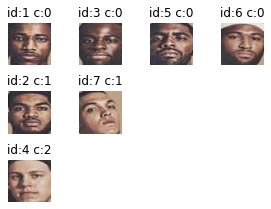

In [ ]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(n_clusters=3).fit(face_embedding) #n_cluster指定群數

# 顯示人臉分群結果
n = clustering.n_clusters_
index = []
for c in range(n):
    idx = np.nonzero(clustering.labels_ == c)[0] 
    index.append(idx)
    
plt.figure(figsize=(10, n))
for c in range(n):
    for idx,face_id in enumerate(index[c]):
        plt.subplot(n, 10,c * 10 + idx +1) #(row數, col數, num)
        plt.axis(False)
        plt.title('id:{} c:{}'.format(face_id + 1, c))
        plt.imshow(face_img[face_id]/255)
        
plt.tight_layout() #自動保持子圖之間的正確間距  

## 人臉辨識

#### 建立資料集

**搜尋並下載Kaggle圖片**

In [ ]:
api_token = {"username":"littlehongman","key":"8fbc4bedc0519be58e56f59fe436cc32"}
import json
import zipfile
import os
 
if not os.path.exists("/root/.kaggle"):
    os.makedirs("/root/.kaggle")
 
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json
 
if not os.path.exists("/kaggle"):
    os.makedirs("/kaggle")
os.chdir('/kaggle')

#找Avengers的資料集
!kaggle datasets list -s avengers

ref                                                               title                                                size  lastUpdated          downloadCount  
----------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
mmmarchetti/avengers                                              Avengers                                              8KB  2020-02-06 22:51:53            291  
rawatjitesh/avengers-face-recognition                             Avengers face recognition!                           55MB  2021-04-26 04:16:32            207  
fivethirtyeight/fivethirtyeight-avengers-dataset                  FiveThirtyEight Avengers Dataset                      9KB  2019-03-26 15:00:24            230  
kavita5/twitter-dataset-avengersendgame                           Twitter Dataset- #AvengersEndgame                   857KB  2019-04-23 15:14:47           1879  
fivethirtyeight/fivethirtyei

In [ ]:
if not os.path.exists('rawatjitesh/avengers-face-recognition '):
    !kaggle datasets download rawatjitesh/avengers-face-recognition 

avengers-face-recognition.zip: Skipping, found more recently modified local copy (use --force to force download)


**解壓縮並分拆圖片**

In [ ]:
!unzip -q /kaggle/avengers-face-recognition.zip

replace cropped_images/chris_evans/chris_evans1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
import splitfolders

splitfolders.ratio('/kaggle/cropped_images', output="Avengers", seed=1337, ratio=(.8, 0.1,0.1)) 

Copying files: 274 files [00:00, 2764.33 files/s]


**計算Embedding並轉成tensor型態**

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img

def getEmbedding(genData):
    X = []
    y = []

    for idx, (filename, c) in enumerate(zip(genData.filenames, genData.classes)):
        #讀取圖片
        img = img_to_array(load_img(os.path.join(genData.directory,filename)))

        #偵測臉部
        results = detector.detect_faces(img)

        #計算embedding
        if len(results) > 0:

            #先取得範圍
            x1, y1, width, height = results[0]['box']
            x1, y1 = abs(x1), abs(y1)
            x2, y2 = x1 + width, y1 + height

            #縮放圖片並取得embedding
            face = tf.image.resize(img[y1:y2,x1:x2],(160,160)) 
            embedding = get_face_embedding(facenet, face)

            X.append(embedding)
            y.append(c)
    
    #tf.constant把 np.array的list 變成tensor
    return tf.concat(X, axis=0), tf.constant(np.array(y))

**取得embedding並以此建立datasets**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Directory = '/kaggle/Avengers/'
datagen = ImageDataGenerator()

#製作機器看得懂的資料集
train_generator = datagen.flow_from_directory(Directory + 'train', batch_size=1)
valid_generator = datagen.flow_from_directory(Directory + 'val', batch_size=1)
test_generator  = datagen.flow_from_directory(Directory + 'test', batch_size=1)

#用mtcnn跟facenet計算embedding作為訓練資料
train_X, train_y = getEmbedding(train_generator)
valid_X, valid_y = getEmbedding(valid_generator)

Found 217 images belonging to 5 classes.
Found 26 images belonging to 5 classes.
Found 31 images belonging to 5 classes.


#### 建立並訓練model

**定義model**

In [ ]:
def create_model(class_indices):
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer((128,)),
        tf.keras.layers.Dense(len(class_indices), activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )

    #讓電腦顯示名字
    model.person_name = {v : k for k,v in class_indices.items()}
  
    return model

**開始訓練**

In [ ]:
model = create_model(train_generator.class_indices)
history = model.fit(train_X,
                    train_y,
                    batch_size=20,
                    validation_data=(valid_X,valid_y),
                    epochs=30,
                    verbose=1)

Epoch 1/30
11/11 [==============================] - 0s 12ms/step - loss: 1.5711 - sparse_categorical_accuracy: 0.3410 - val_loss: 1.5305 - val_sparse_categorical_accuracy: 0.4615
Epoch 2/30
11/11 [==============================] - 0s 3ms/step - loss: 1.5084 - sparse_categorical_accuracy: 0.6590 - val_loss: 1.4678 - val_sparse_categorical_accuracy: 0.8462
Epoch 3/30
11/11 [==============================] - 0s 5ms/step - loss: 1.4483 - sparse_categorical_accuracy: 0.8571 - val_loss: 1.4067 - val_sparse_categorical_accuracy: 1.0000
Epoch 4/30
11/11 [==============================] - 0s 4ms/step - loss: 1.3895 - sparse_categorical_accuracy: 0.9171 - val_loss: 1.3474 - val_sparse_categorical_accuracy: 1.0000
Epoch 5/30
11/11 [==============================] - 0s 3ms/step - loss: 1.3325 - sparse_categorical_accuracy: 0.9539 - val_loss: 1.2898 - val_sparse_categorical_accuracy: 1.0000
Epoch 6/30
11/11 [==============================] - 0s 4ms/step - loss: 1.2774 - sparse_categorical_accuracy:

#### 顯示每個epoch的Accuracy跟Loss

Text(0.5, 0, 'epoch')

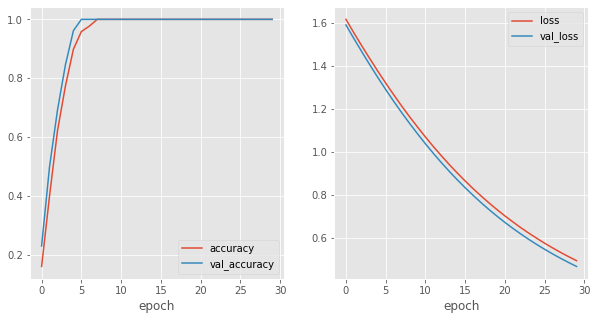

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(10,5))

#Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['sparse_categorical_accuracy'],label='accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'],label='val_accuracy')
plt.xlabel('epoch')
plt.legend()

#Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()
plt.xlabel('epoch')

#### 儲存、載入model
之後使用此模型只要載入即可，不需要再重新訓練。

In [ ]:
model.save('face_model.h5') #model.save('path/to/location')
with open('face_model.pickle','wb') as f:
    pickle.dump(model.person_name,f)

In [ ]:
cmodel = tf.keras.models.load_model('face_model.h5')
with open('face_model.pickle','rb') as f:
    cmodel.person_name = pickle.load(f)

#### 根據model顯示人臉和姓名

In [ ]:
def face_recognition(facenet,classifier,face_image):
    #取得embedding
    embedding = get_face_embedding(facenet, face_image)

    #根據model取得機率 (ex:[[0.5437059  0.1726566  0.11233554 0.09588948 0.07541244]])
    prob  = classifier.predict(embedding)
    
    #tf.math.argmax取最大值
    name  = classifier.person_name[tf.math.argmax(prob,axis=1).numpy()[0]]      
    return name

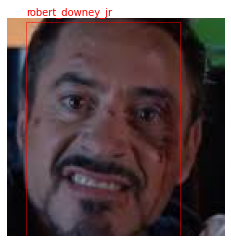

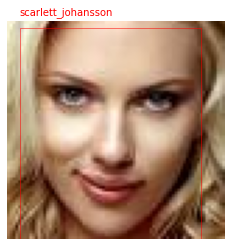

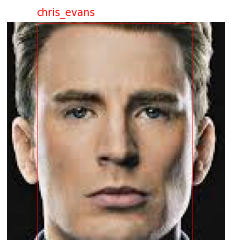

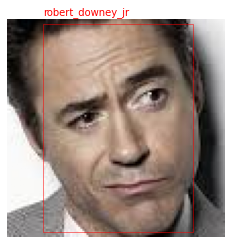

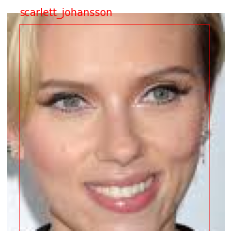

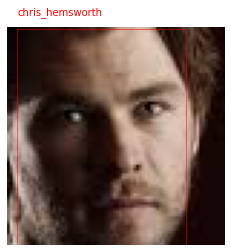

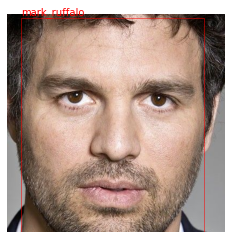

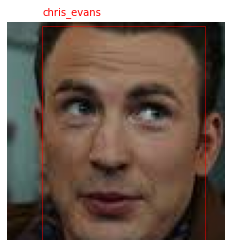

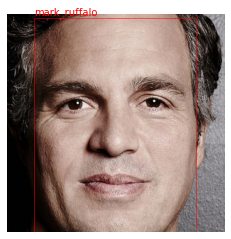

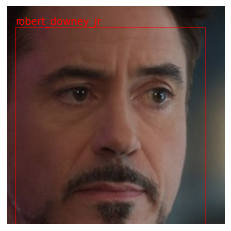

In [ ]:
import matplotlib.patches as mpatches
from tensorflow.keras.preprocessing.image import img_to_array, load_img

#隨機從測試集隨機取10張圖片
for idx in np.random.permutation(len(test_generator.filenames))[:10]:
    
    #載入影像
    filename = test_generator.filenames[idx]
    img = img_to_array(load_img(os.path.join(test_generator.directory, filename)))

    #顯示圖片
    plt.figure()
    plt.axis(False)
    ax = plt.gca() #得到當前的 axes(畫圖物件)
    plt.imshow(img/255)

    #人臉偵測
    results = detector.detect_faces(img)
    
    #辨識人臉
    for f in results:
        #取臉部範圍
        x1, y1, width, height = f['box']
        x1, y1 = abs(x1), abs(y1)
        x2, y2 = x1 + width, y1 + height
        
        #縮放圖片並取得embedding
        face = tf.image.resize(img[y1:y2,x1:x2],(160,160)) 
        name = face_recognition(facenet, model, face)
        
        #在圖片上加上方框和名字
        ax.add_patch(mpatches.Rectangle((x1, y1),width, height, ec='red',alpha=1, fill=None))
        plt.text(x1,y1 - 5, name, color='red')